## Polya-Gamma Augmentation for Logistic Regression 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
from numpy.linalg import inv
from pypolyagamma import PyPolyaGamma
from scipy.stats import multivariate_normal


# シグモイド関数
def sigmoid(x):
    """Numerically stable sigmoid function."""
    return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))


def multi_pgdraw(pg, B, C):
    """Utility function for calling `pgdraw` on every pair in vectors B, C."""
    return np.array([pg.pgdraw(b, c) for b, c in zip(B, C)])


# 1次元のロジスティック回帰モデル
def gen_bimodal_data(N, p):
    """Generate bimodal data for easy sanity checking."""
    y = npr.random(N) < p
    X = np.empty(N)
    X[y] = npr.normal(0, 1, size=y.sum())
    X[~y] = npr.normal(4, 1.4, size=(~y).sum())
    return X, y.astype(int)


# Set priors and create data.
N_train = 1000
N_test = 1000
b = np.zeros(2)
B = np.diag(np.ones(2))
X_train, y_train = gen_bimodal_data(N_train, p=0.3)
X_test, y_test = gen_bimodal_data(N_test, p=0.3)
# Prepend 1 for the bias β_0.
X_train = np.vstack([np.ones(N_train), X_train])
X_test = np.vstack([np.ones(N_test), X_test])

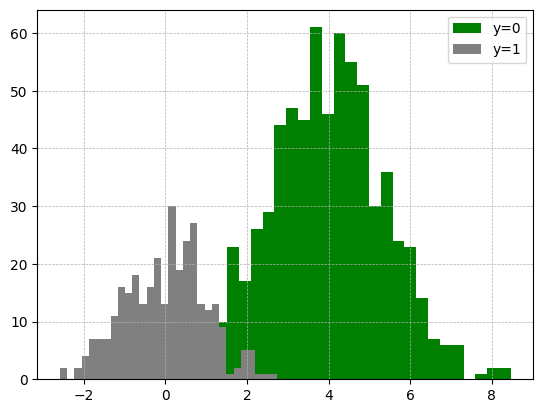

In [2]:
bins = np.linspace(X_train.min() - 3.0, X_train.max() + 3, 100)
plt.hist(X_train[1, y_train == 0], bins=30, label="y=0", color="green")
plt.hist(X_train[1, y_train == 1], bins=30, label="y=1", color="grey")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()

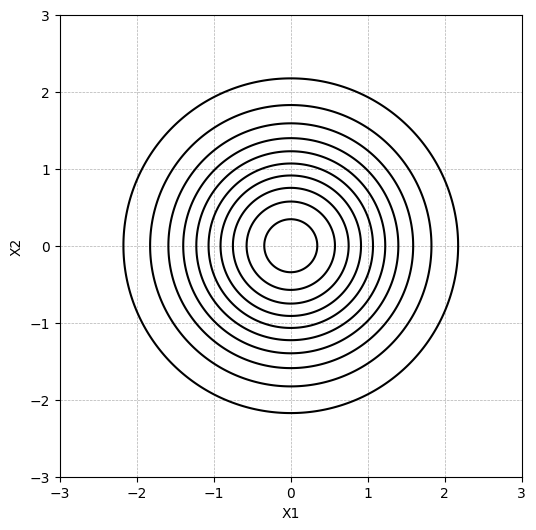

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 平均ベクトルと共分散行列の設定
b = np.zeros(2)
B = np.diag(np.ones(2))

# グリッドの生成
x, y = np.mgrid[-3:3:0.01, -3:3:0.01]
pos = np.dstack((x, y))

# 多変量正規分布の定義
rv = multivariate_normal(mean=b, cov=B)

# 等高線プロットの作成
plt.figure(figsize=(6, 6))
plt.contour(x, y, rv.pdf(pos), levels=10, colors="black")
plt.xlabel("X1")
plt.ylabel("X2")
plt.xticks(np.arange(-3, 4, 1))
plt.yticks(np.arange(-3, 4, 1))
plt.grid(True, linestyle="--", linewidth=0.5)  # グリッド線を追加
plt.gca().set_aspect("equal", adjustable="box")  # アスペクト比を1:1に設定
plt.show()

100%|██████████| 10000/10000 [00:20<00:00, 485.60it/s]


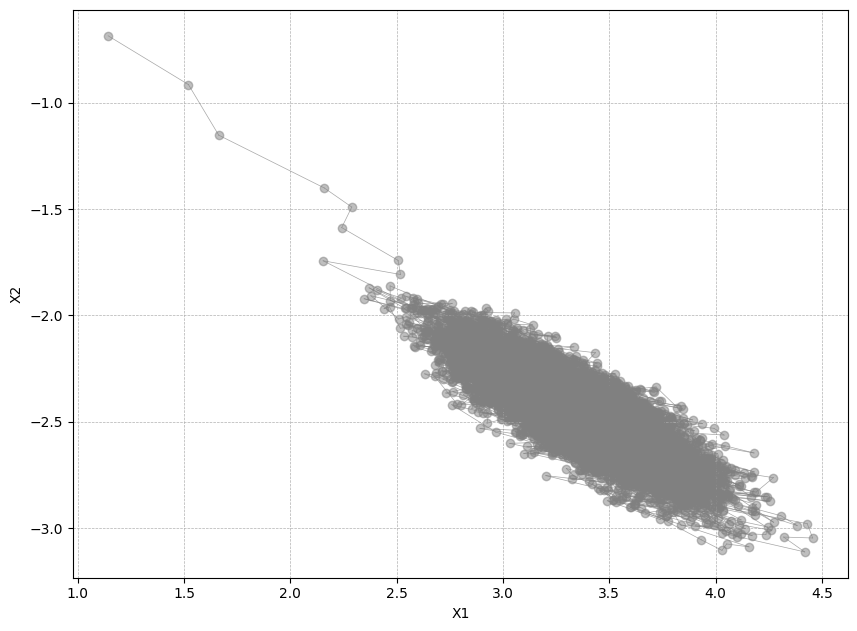

In [4]:
import matplotlib.cm as cm
from tqdm import tqdm

# Peform Gibbs sampling for T iterations.
pg = PyPolyaGamma()
T = 10000
Omega_diag = np.ones(N_train)
beta_hat = npr.multivariate_normal(b, B)
k = y_train - 1 / 2.0

beta_list = []
for _ in tqdm(range(T)):
    # ω ~ PG(1, x*β).
    Omega_diag = multi_pgdraw(pg, np.ones(N_train), X_train.T @ beta_hat)
    # β ~ N(m, V).
    V = inv(X_train @ np.diag(Omega_diag) @ X_train.T + inv(B))
    m = np.dot(V, X_train @ k + inv(B) @ b)
    beta_hat = npr.multivariate_normal(m, V)
    beta_list.append(beta_hat)

beta_list = np.array(beta_list)

# Plot the posterior distribution of β.
plt.figure(figsize=(10, 10))
# カラーマップの作成
colors = cm.viridis(np.linspace(0, 1, T))

plt.scatter(beta_list[:, 0], beta_list[:, 1], c="grey", alpha=0.5)

# サンプルの点を線で繋ぐ
for i in range(1, T):
    plt.plot(
        beta_list[i - 1 : i + 1, 0],
        beta_list[i - 1 : i + 1, 1],
        color="grey",
        alpha=0.7,
        lw=0.5,
    )

plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True, linestyle="--", linewidth=0.5)  # グリッド線を追加
plt.gca().set_aspect("equal", adjustable="box")  # アスペクト比を1:1に設定
plt.show()

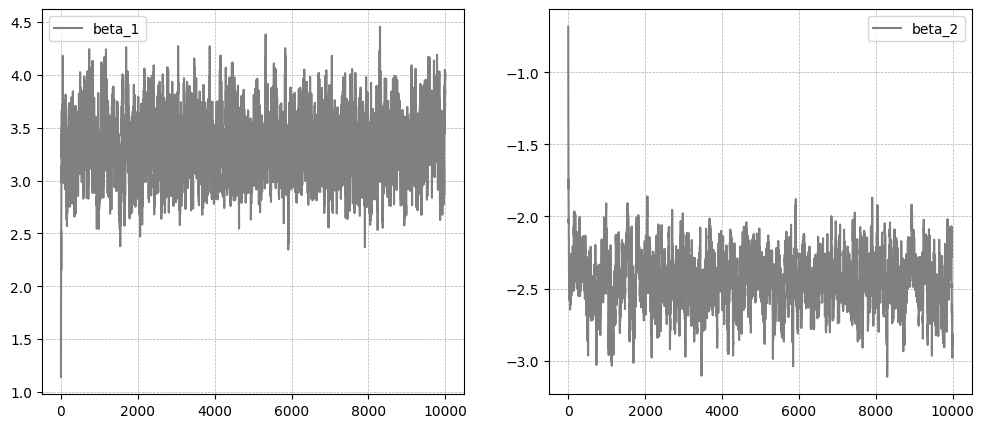

In [5]:
plt.figure(figsize=(12, 5))
# plt.title('Posterior Distribution of Beta')
# beta_list[:, 0]をTを横軸にしてプロット
plt.subplot(1, 2, 1)
plt.plot(beta_list[:, 0], c="grey", label="beta_1")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(beta_list[:, 1], c="grey", label="beta_2")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()

plt.show()

In [5]:
# バーンイン期間を15としてそれ以降の平均でMAP推定
beta_mpe = beta_list[15:].mean(axis=0)
beta_mpe

array([ 3.19682694, -2.34366923])

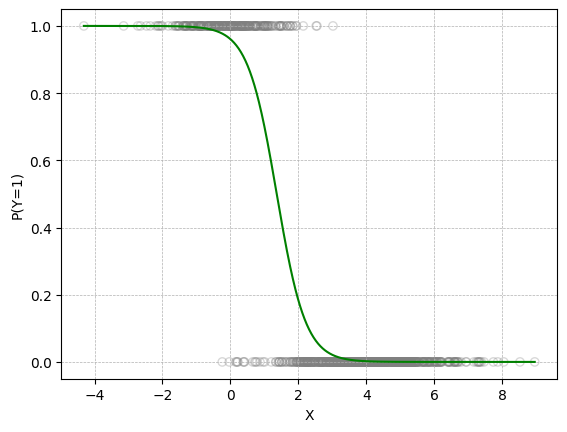

In [6]:
plt.scatter(
    X_train[1],
    y_train,
    facecolor="None",
    edgecolor="grey",
    marker="o",
    alpha=0.3,
    label="Observed Data",
)

x = np.linspace(X_train[1].min(), X_train[1].max(), 1000)
y = sigmoid(beta_mpe @ np.vstack([np.ones(1000), x]))
plt.plot(x, y, c="green", label="MPE Prediction")
plt.xlabel("X")
plt.ylabel("P(Y=1)")
plt.grid(True, linestyle="--", linewidth=0.5)

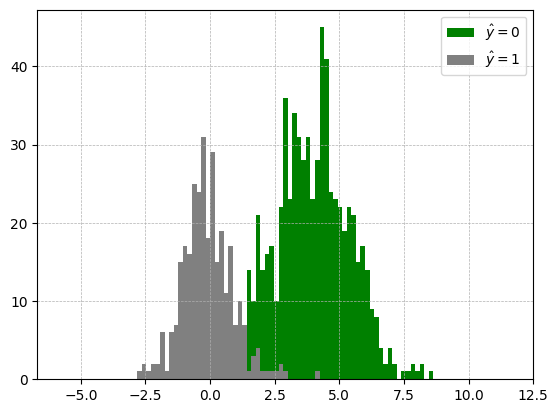

In [7]:
y_pred = npr.binomial(1, sigmoid(X_test.T @ beta_hat))
bins = np.linspace(X_test.min() - 3.0, X_test.max() + 3, 100)
plt.hist(X_test.T[y_pred == 0][:, 1], color="green", bins=bins, label=r"$\hat{y}=0$")
plt.hist(X_test.T[~(y_pred == 0)][:, 1], color="grey", bins=bins, label=r"$\hat{y}=1$")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.legend()

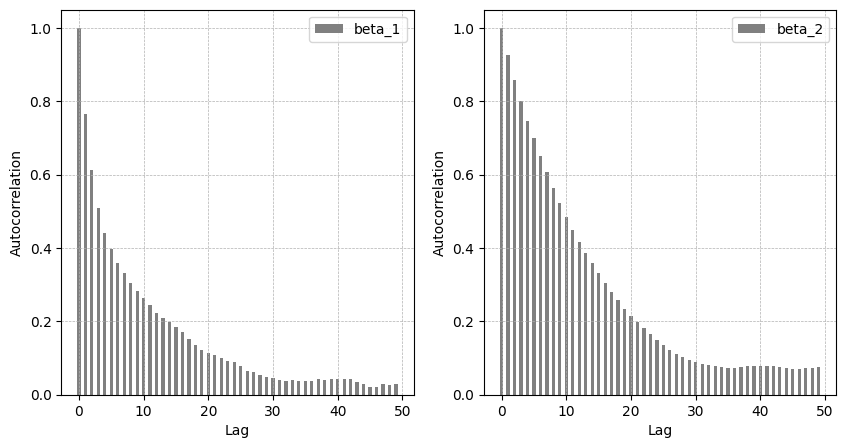

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 自己相関の計算
autocorrelation_1 = [pd.Series(beta_list[:, 0]).autocorr(lag=i) for i in range(50)]
autocorrelation_2 = [pd.Series(beta_list[:, 1]).autocorr(lag=i) for i in range(50)]

# 自己相関のプロット


plt.figure(figsize=(10, 5))
# plt.title('Autocorrelation of MCMC Samples of Beta')

plt.subplot(1, 2, 1)
plt.bar(range(50), autocorrelation_1, width=0.5, color="grey", label="beta_1")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(range(50), autocorrelation_2, width=0.5, color="grey", label="beta_2")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.legend()

plt.show()